
Author: __Adonis González Godoy__ 

# Redes Neuronales Recurrentes

Trabajaremos con redes neuronales recurrentes LSTM para predecir diversas características de una serie temporal. Concretamente, trabajaremos con la serie formada por los precios del cambio EUR-USD durante algunos días del mes de mayo de 2019 y consideraremos dos tipos de problemas:

<ol start="1">
    <li>Problema de regresión para predecir valores futuros de la serie.</li>
    <li>Problema de clasificación para predecir tendencias de la serie.</li>
</ol>


## 0. Inicialización, carga de datos y utilidades

El código siguiente carga algunos paquetes necesarios y lee los datos que utilizaremos para entrenar las redes neuronales. Definimos también algunas utilidades para preprocesar los datos y generar los datasets.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 7] #16 12

In [3]:
eur_usd = pd.read_csv("EUR_USD_05_2019.csv", index_col="time", parse_dates=["time"])
eur_usd

,volume,price
time,,
2019-05-05 21:00:00+00:00,39.0,1.11855
2019-05-05 21:05:00+00:00,21.0,1.11806
2019-05-05 21:10:00+00:00,4.0,1.11798
2019-05-05 21:15:00+00:00,10.0,1.11784
2019-05-05 21:20:00+00:00,4.0,1.11809
...,...,...
2019-05-31 20:40:00+00:00,6.0,1.11674
2019-05-31 20:45:00+00:00,2.0,1.11672
2019-05-31 20:50:00+00:00,7.0,1.11694


In [4]:
# eur_usd.iloc[0:26]

<AxesSubplot:xlabel='time'>

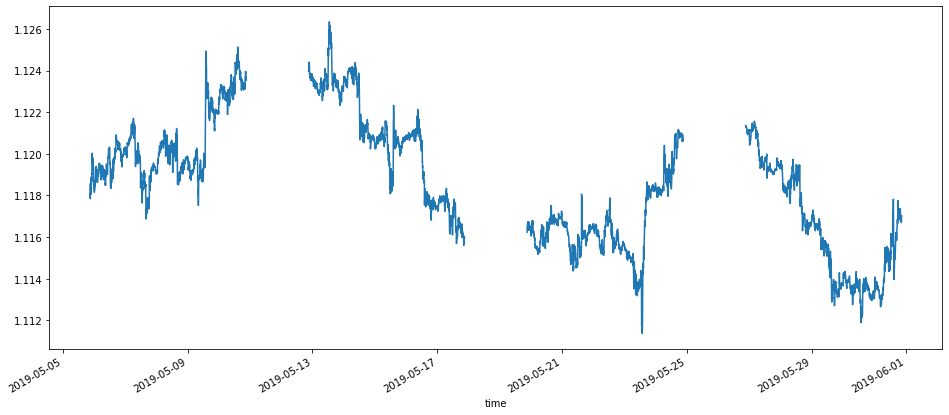

In [5]:
eur_usd["price"].plot()

El dataset contiene el precio cada 5 minutos durante cuatro semanas de mayo de 2019. El mercado FOREX opera del domingo a las 21h hasta el viernes de la siguiente semana a las 21h. Para hacer que el modelo no vea los espacios entre los fines de semana separamos los datos en cuatro variables, una para cada semana. Utilizaremos las tres primeras semanas para entrenar los modelos y la cuarta semana para hacer la validación.

In [6]:
week1 = eur_usd["2019-05-05 21:00:00":"2019-05-10 21:00:00"].copy()
week2 = eur_usd["2019-05-12 21:00:00":"2019-05-17 21:00:00"].copy()
week3 = eur_usd["2019-05-19 21:00:00":"2019-05-24 21:00:00"].copy()
week4 = eur_usd["2019-05-26 21:00:00":"2019-05-31 21:00:00"].copy()

In [7]:
week1.shape

(1441, 2)

A continuación definimos la medida de las ventanas con las que queremos trabajar. Como tenemos valores de la serie cada 5 minutos, definiendo *lookback* con el valor 24 y *future* con el valor 2 lo que haremos a continuación será generar registros que contengan los valores históricos de las últimas dos horas y tales que el valor a predecir será el valor de la serie al cabo de 10 minutos.

In [8]:
lookback = 24
future = 2

La siguiente función nos será de utilidad para generar los conjuntos de datos necesarios para entrenar las redes neuronales. Concretamente, dada una serie temporal, genera diferentes registros de forma que cada registro tiene tantos valores hacia el pasado como se indica en la variable *lookback* y el label de cada registro corresponde al valor de la serie en el futuro, donde la distancia del punto a predecir viene definida en la variable *future*.

In [9]:
def create_dataset(series, lookback, future):
    features_set = [] 
    labels = []  
    for i in range(lookback, series.shape[0] - future):  
        features_set.append(series[i - lookback:i])
        labels.append(series[i + future - 1])

    features_set, labels = np.array(features_set), np.array(labels)
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

    return features_set, labels

La siguiente función recibe un dataframe y un vector de predicciones y genera una nueva columna en el dataframe con las predicciones, teniendo en cuenta los valores de *lookback* y *future*, ya que las longitudes del dataframe y el vector de predicciones serán diferentes.

In [10]:
def add_predictions(df, preds):
    predictions = np.ones(len(df)) * np.nan
    predictions[lookback+future-1:-1] = preds[:, 0]
    df.loc[:, "lstm_preds"] = predictions
    return df

## 1. Red neuronal recurrente para un problema de regresión

En este apartado entrenaremos una red neuronal que intente predecir el precio del cambio EUR-USD en un momento futuro. El primer paso consiste en normalizar los datos y generar los datasets correspondientes.

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [12]:
# scaler = MinMaxScaler(feature_range = (0, 1))
scaler = StandardScaler()

In [13]:
w1_pre = week1.dropna()
w2_pre = week2.dropna()
w3_pre = week3.dropna()
w4_pre = week4.dropna()

In [14]:
weeks_X = pd.concat([week1, week2, week3])
weeks_X = weeks_X['price'].to_numpy().reshape(-1,1)

In [15]:
weeks_X = scaler.fit(weeks_X)

In [16]:
week1_scaled = weeks_X.transform(week1['price'].to_numpy().reshape(-1,1))
week2_scaled = weeks_X.transform(week2['price'].to_numpy().reshape(-1,1))
week3_scaled = weeks_X.transform(week3['price'].to_numpy().reshape(-1,1))
week4_scaled = weeks_X.transform(week4['price'].to_numpy().reshape(-1,1))

In [17]:
feature_w1, lbl_w1 = create_dataset(week1_scaled, lookback, future)
feature_w2, lbl_w2 = create_dataset(week2_scaled, lookback, future)
feature_w3, lbl_w3 = create_dataset(week3_scaled, lookback, future)
feature_w4, lbl_w4 = create_dataset(week4_scaled, lookback, future)

In [18]:
# join three weeks
X = np.concatenate([feature_w1, feature_w2, feature_w3])
X_lbls = np.concatenate([lbl_w1, lbl_w2, lbl_w3])

In [19]:
print(f'Features shape of three weeks = {X.shape}')
print(f'Labels shape of three weeks = {X_lbls.shape}')

Features shape of three weeks = (4245, 24, 1)
Labels shape of three weeks = (4245, 1)


In [20]:
print(f'Features shape of last week = {feature_w4.shape}')
print(f'Labels shape of last week = {lbl_w4.shape}')

Features shape of last week = (1415, 24, 1)
Labels shape of last week = (1415, 1)


In [21]:
from keras import Sequential, Model
from keras.optimizers import Adam
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
from keras.layers import LSTM
from keras import Input

In [22]:
units = 50
epochs = 10

In [23]:
model = Sequential()
model.add(LSTM(units, input_shape=(24, 1)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(
    optimizer=Adam(lr=0.1),
    loss='mean_squared_error', 
    metrics=["accuracy"])

In [24]:
hist = model.fit(X, X_lbls, epochs=epochs, batch_size=32, verbose=2)

Epoch 1/10
133/133 - 3s - loss: 0.2558 - accuracy: 0.0000e+00
Epoch 2/10
133/133 - 1s - loss: 0.0268 - accuracy: 0.0000e+00
Epoch 3/10
133/133 - 0s - loss: 0.0187 - accuracy: 0.0000e+00
Epoch 4/10
133/133 - 0s - loss: 0.0174 - accuracy: 0.0000e+00
Epoch 5/10
133/133 - 0s - loss: 0.0199 - accuracy: 0.0000e+00
Epoch 6/10
133/133 - 0s - loss: 0.0168 - accuracy: 0.0000e+00
Epoch 7/10
133/133 - 1s - loss: 0.0195 - accuracy: 0.0000e+00
Epoch 8/10
133/133 - 1s - loss: 0.0184 - accuracy: 0.0000e+00
Epoch 9/10
133/133 - 1s - loss: 0.0166 - accuracy: 0.0000e+00
Epoch 10/10
133/133 - 1s - loss: 0.0183 - accuracy: 0.0000e+00


Generaramos las predicciones de cada semana por separado. Entonces, desnormalizamos las predicciones.

El siguiente código muestra la serie original junto con las predicciones de la red neuronal.

In [25]:
# prediction for each week
w1_prediction = model.predict(feature_w1)
w2_prediction = model.predict(feature_w2)
w3_prediction = model.predict(feature_w3)
w4_prediction = model.predict(feature_w4)

In [26]:
# inverse transfor for each week
w1_pre_inv = scaler.inverse_transform(w1_prediction)
w2_pre_inv = scaler.inverse_transform(w2_prediction)
w3_pre_inv = scaler.inverse_transform(w3_prediction)
w4_pre_inv = scaler.inverse_transform(w4_prediction)

In [27]:
# add predictions
week1_p = add_predictions(week1, w1_pre_inv)
week2_p = add_predictions(week2, w2_pre_inv)
week3_p = add_predictions(week3, w3_pre_inv)
week4_p = add_predictions(week4, w4_pre_inv)

In [28]:
eur_usd_lstm_preds = pd.concat([week1_p, week2_p, week3_p, week4_p])

<AxesSubplot:xlabel='time'>

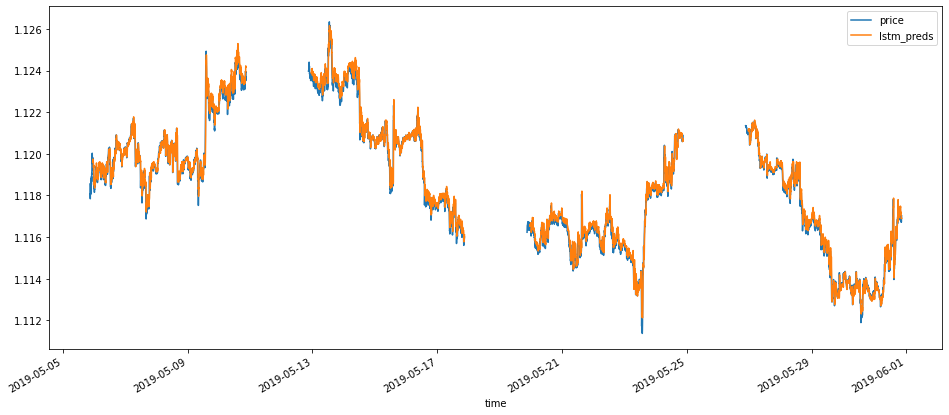

In [29]:
eur_usd_lstm_preds[["price", "lstm_preds"]].plot()

Se observa la predicción en la serie de color naranja, parece que el modelo da buenos resultados ya que se ajusta con la serie original.

Con el siguiente código podemos generar la gráfica sólo de una parte de la cuarta semana, que corresponde al conjunto de validación.

<AxesSubplot:xlabel='time'>

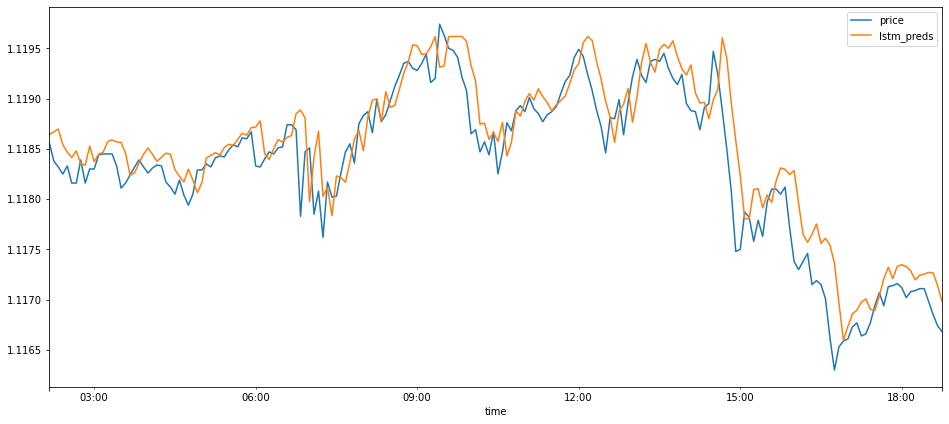

In [30]:
week4_p.iloc[350:550][["price", "lstm_preds"]].plot()

La predicción sobre el conjunto test se puede ver que no se ajusta tanto como en el conjunto de entramiento.
El modelo parece acercarse bastante pero no lo suficiente para decir que esta funcionando de manera óptima.

El siguiente código genera una nueva predicción para cada punto de la cuarta semana que consiste en copiar el último valor conocido de la serie en cada momento para hacer la predicción.

In [31]:
week4_p["previous_day"] = week4_p["price"].shift(future)

Calculamos el rmse de la LSTM y de las predicciones anteriores sobre la cuarta semana 

In [32]:
y_actual = eur_usd_lstm_preds["price"]
y_predicted = week4_p["lstm_preds"]
# y_predicted = week4["lstm_preds"]
MSE = np.square(np.subtract(y_actual,y_predicted)).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.00027635097452597914


En los gráficos anteriores es más intuitivo comparar, pero el Error de Media Cuadrática nos informa sobre el tamaño de los errores de las predicciones, el error medio absoluto obtenido es 0.00027.

## 2. Red neuronal recurrente para un problema de clasificación

Dado que parece imposible predecir correctamente la serie temporal utilizando una red neuronal, lo que haremos será transformar el problema de regresión en un problema de clasificación, entrenando una red neuronal que prediga solo si el precio subirá o bajará.

In [33]:
def create_dataset_clas(series, lookback, future):
    features_set, labels = [], []
    for i in range(lookback, series.shape[0] - future):
        features_set.append(series[i - lookback:i])
        if series[i + future - 1]>series[i-1]:
            if abs((series[i + future - 1]-series[i-1])/series[i-1])>0.1:
                labels.append(1)
            else:
                labels.append(0)
        else:
            labels.append(0)
    features_set, labels = np.array(features_set), np.array(labels)
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
    return features_set, labels

In [34]:
# crate datasets
featWeek_1, lblBin_w1 = create_dataset_clas(week1_scaled, lookback, future)
featWeek_2, lblBin_w2 = create_dataset_clas(week2_scaled, lookback, future)
featWeek_3, lblBin_w3 = create_dataset_clas(week3_scaled, lookback, future)
featWeek_4, lblBin_w4 = create_dataset_clas(week4_scaled, lookback, future)

In [35]:
X_2 = np.concatenate([featWeek_1, featWeek_2, featWeek_3])
X_lbls_2 = np.concatenate([lblBin_w1, lblBin_w2, lblBin_w3])

In [36]:
print(f'Num total 0s en las primeras semanas: {(X_lbls_2 == 0).sum()}')
print(f'Num total 1s en las primeras semanas: {(X_lbls_2 == 1).sum()}')

Num total 0s en las primeras semanas: 3429
Num total 1s en las primeras semanas: 816


In [37]:
print(f'Features shape of three weeks = {X_2.shape}')
print(f'Labels shape of three weeks = {X_lbls_2.shape}')

Features shape of three weeks = (4245, 24, 1)
Labels shape of three weeks = (4245,)


In [38]:
print(f'Features shape of last week = {featWeek_4.shape}')
print(f'Labels shape of last week = {lblBin_w4.shape}')

Features shape of last week = (1415, 24, 1)
Labels shape of last week = (1415,)


In [39]:
np.unique(X_lbls_2, return_counts=True)

(array([0, 1]), array([3429,  816], dtype=int64))

In [40]:
np.unique(lblBin_w4, return_counts=True)

(array([0, 1]), array([1204,  211], dtype=int64))

Los datos se encuentran desbalanceados entre sus dos clases.

In [41]:
from keras.metrics import BinaryAccuracy
from keras.metrics import AUC

In [42]:
epochs = 20

In [43]:
from keras.optimizers import Adam

model = Sequential()

model.add(LSTM(50, return_sequences=False, input_shape=(24,1)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=0.1),
              metrics=[['accuracy'],
                       BinaryAccuracy(), 
                       AUC(curve="ROC"), 
                       AUC(curve="PR")])

In [44]:
hist_2 = model.fit(X_2, X_lbls_2, validation_split = 0.1, epochs=epochs, batch_size=32, verbose=2)

Epoch 1/20
120/120 - 4s - loss: 0.4503 - accuracy: 0.8099 - binary_accuracy: 0.8099 - auc: 0.6952 - auc_1: 0.3106 - val_loss: 0.6055 - val_accuracy: 0.7271 - val_binary_accuracy: 0.7271 - val_auc: 0.5827 - val_auc_1: 0.3254
Epoch 2/20
120/120 - 1s - loss: 0.4129 - accuracy: 0.8157 - binary_accuracy: 0.8157 - auc: 0.7527 - auc_1: 0.3798 - val_loss: 0.6300 - val_accuracy: 0.7176 - val_binary_accuracy: 0.7176 - val_auc: 0.6530 - val_auc_1: 0.4277
Epoch 3/20
120/120 - 1s - loss: 0.4484 - accuracy: 0.8178 - binary_accuracy: 0.8178 - auc: 0.6645 - auc_1: 0.2800 - val_loss: 0.6517 - val_accuracy: 0.7176 - val_binary_accuracy: 0.7176 - val_auc: 0.6027 - val_auc_1: 0.3572
Epoch 4/20
120/120 - 1s - loss: 0.4573 - accuracy: 0.8178 - binary_accuracy: 0.8178 - auc: 0.6041 - auc_1: 0.2146 - val_loss: 0.6278 - val_accuracy: 0.7176 - val_binary_accuracy: 0.7176 - val_auc: 0.5426 - val_auc_1: 0.3007
Epoch 5/20
120/120 - 1s - loss: 0.4527 - accuracy: 0.8178 - binary_accuracy: 0.8178 - auc: 0.6183 - auc_

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, average_precision_score

In [46]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train val', 'Val val'], loc='upper right')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epochs') 
    plt.legend(['Train loss', 'Val loss'], loc='upper right') 
    plt.show()

In [47]:
y_pred = model.predict_proba(featWeek_4)
auc = roc_auc_score(lblBin_w4, y_pred)
print(auc)

0.781840940939365


In [48]:
fpr, tpr, thresholds = roc_curve(lblBin_w4, y_pred)

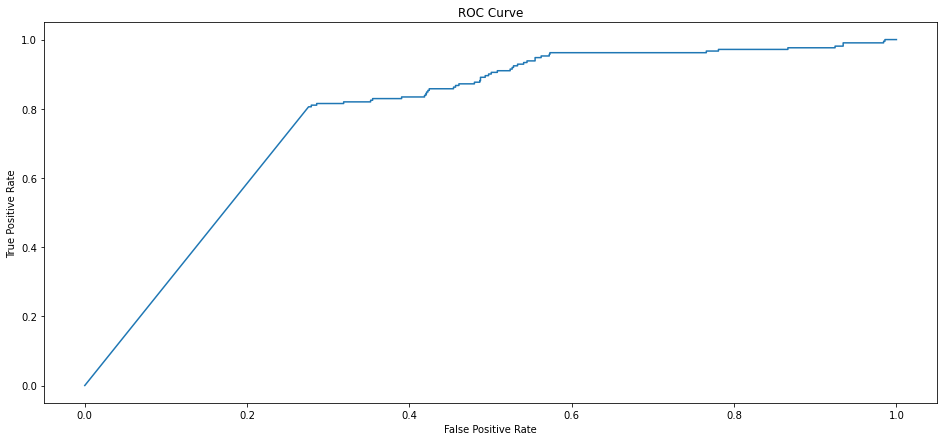

In [49]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [50]:
precision, recall, thresholds = precision_recall_curve(lblBin_w4, y_pred)

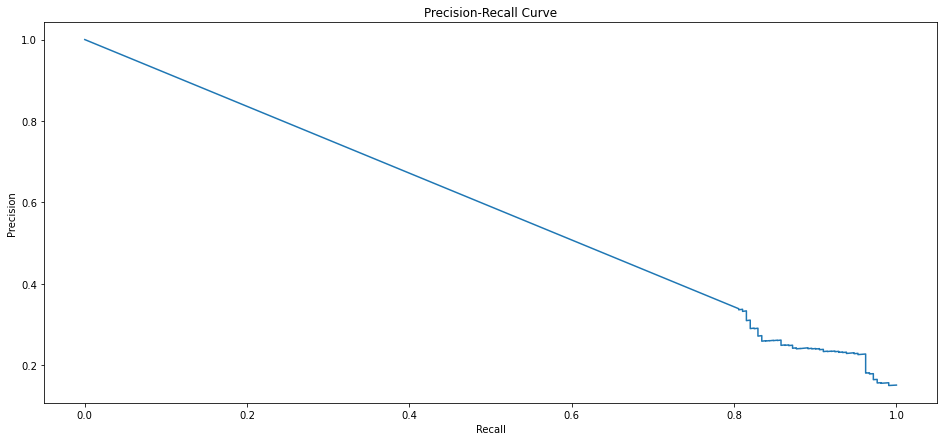

In [51]:
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

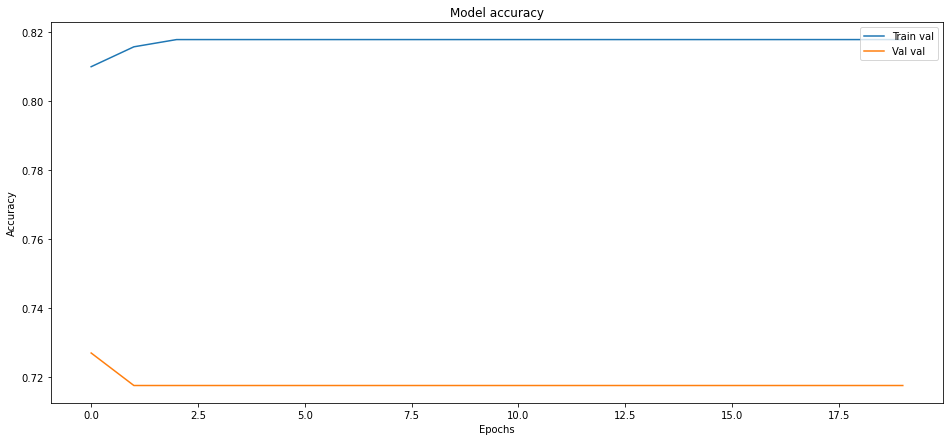

In [52]:
plot_accuracy(hist_2)

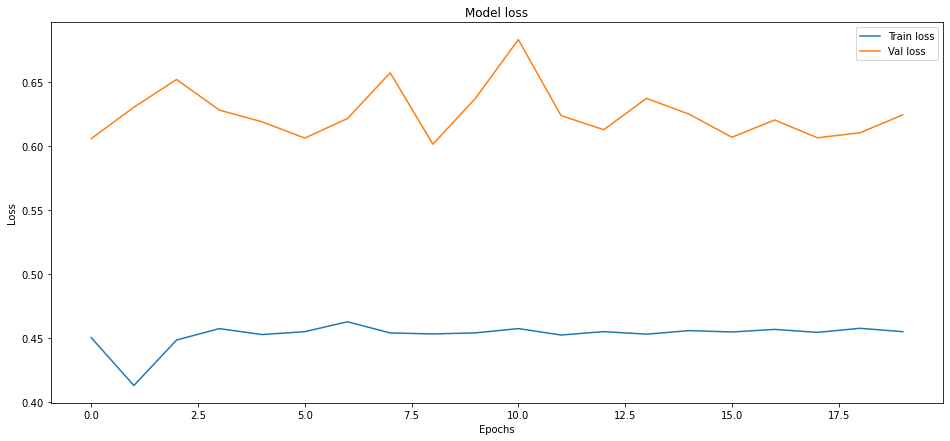

In [53]:
plot_loss(hist_2)

In [54]:
 print(f'Avg. Prec.: {round(average_precision_score(lblBin_w4, y_pred),2)}')

Avg. Prec.: 0.32


<hr></hr>
La metrica ROC obtiene la tasa de falsos positivos, la tasa de los verdaros 
positivos y los umbrales para decidir, este modelo ha obtenido un auc de 0.78. Tanto la métrica ROC como PR contienen los mismos puntos. Parece que los TPR dan buenos resultados.
Se podría usar el threshold para decidir un modelo.
<hr></hr>

## 3. Red neuronal recurrente con variables adicionales

El dataset original con la serie de precios del EUR-USD contiene también la variable *volume*, que indica cuántas operaciones se han hecho durante cada periodo de 5 minutos. Esta información puede ser útil para intentar predecir si el precio se moverá mucho o no, por lo que podemos añadir la variable como entrada de la red neuronal recurrente.

In [55]:
def create_dataset_class_2(series, lookback, future):
    df = pd.DataFrame(series, columns=['volume','price'])
    features_set, labels = [], []
    for i in range(lookback, df['price'].shape[0] - future):
        features_set.append(df[i - lookback:i])
        if df['price'][i + future - 1] > df['price'][i-1]:
            if abs((df['price'][i + future - 1] - df['price'][i-1])/df['price'][i-1])>0.1:
                labels.append(1)
            else:
                labels.append(0)
        else:
            labels.append(0)
    features_set, labels = np.array(features_set), np.array(labels)
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 2))
    return features_set, labels

Normalizamos los valores de la serie temporal (tanto del volumen como del precio) utilizando solo las tres primeras semanas para calcular las estadísticas.

In [56]:
# is ltsm_predc 
# week1.iloc[:,:-1]

In [57]:
data = pd.concat([week1.iloc[:,:-1],week2.iloc[:,:-1],week3.iloc[:,:-1]])
size_week = week1.shape[0]

In [58]:
sc_data = StandardScaler()
sc_data.fit(data)
data_scaled = sc_data.transform(data)

In [59]:
sc_w1 = data_scaled[0:size_week,:]
sc_w2 = data_scaled[size_week:2*size_week,:]
sc_w3 = data_scaled[2*size_week:,:]

In [60]:
week4 = eur_usd["2019-05-26 21:00:00":"2019-05-31 21:00:00"].copy()
sc_w4 = sc_data.transform(week4)

In [61]:
df1 = pd.DataFrame(sc_w1, columns=['volume','price'])
df2 = pd.DataFrame(sc_w2, columns=['volume','price'])
df3 = pd.DataFrame(sc_w3, columns=['volume','price'])
df4 = pd.DataFrame(sc_w4, columns=['volume','price'])

In [78]:
# df1.head(5)

In [63]:
feature_w1, lbl_w1 = create_dataset_class_2(df1, lookback, future)
feature_w2, lbl_w2 = create_dataset_class_2(df2, lookback, future)
feature_w3, lbl_w3 = create_dataset_class_2(df3, lookback, future)

In [64]:
feature_w4, lbl_w4 = create_dataset_class_2(df4, lookback, future)

In [65]:
# join
X_3 = np.concatenate([feature_w1, feature_w2, feature_w3], axis=0)
X_lbls_3 = np.concatenate([lbl_w1, lbl_w2, lbl_w3])

In [66]:
print(f'Features shape of week = {feature_w1.shape}')

Features shape of week = (1415, 24, 2)


In [67]:
print(f'Features shape of three weeks = {X_3.shape}')
print(f'Labels shape of three weeks = {X_lbls_3.shape}')

Features shape of three weeks = (4245, 24, 2)
Labels shape of three weeks = (4245,)


In [68]:
print(f'Features shape of last week = {feature_w4.shape}')
print(f'Labels shape of last week = {lbl_w4.shape}')

Features shape of last week = (1415, 24, 2)
Labels shape of last week = (1415,)


In [69]:
from keras.optimizers import Adam

model = Sequential()

model.add(LSTM(50, return_sequences=False, input_shape=(X_3.shape[1],2)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=0.1),
              metrics=[['accuracy'],
                       BinaryAccuracy(), 
                       AUC(curve="ROC"), 
                       AUC(curve="PR")])

In [70]:
hist_3 = model.fit(X_3, X_lbls_3, validation_split = 0.1, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
120/120 - 3s - loss: 0.4760 - accuracy: 0.8141 - binary_accuracy: 0.8141 - auc_2: 0.5952 - auc_3: 0.2202 - val_loss: 0.6146 - val_accuracy: 0.7176 - val_binary_accuracy: 0.7176 - val_auc_2: 0.5000 - val_auc_3: 0.2824
Epoch 2/20
120/120 - 1s - loss: 0.4678 - accuracy: 0.8178 - binary_accuracy: 0.8178 - auc_2: 0.5587 - auc_3: 0.2018 - val_loss: 0.6127 - val_accuracy: 0.7176 - val_binary_accuracy: 0.7176 - val_auc_2: 0.4991 - val_auc_3: 0.2820
Epoch 3/20
120/120 - 1s - loss: 0.4613 - accuracy: 0.8178 - binary_accuracy: 0.8178 - auc_2: 0.5689 - auc_3: 0.2022 - val_loss: 0.7310 - val_accuracy: 0.7176 - val_binary_accuracy: 0.7176 - val_auc_2: 0.5053 - val_auc_3: 0.2827
Epoch 4/20
120/120 - 1s - loss: 0.4845 - accuracy: 0.8178 - binary_accuracy: 0.8178 - auc_2: 0.4846 - auc_3: 0.1762 - val_loss: 0.6193 - val_accuracy: 0.7176 - val_binary_accuracy: 0.7176 - val_auc_2: 0.5049 - val_auc_3: 0.2844
Epoch 5/20
120/120 - 1s - loss: 0.4756 - accuracy: 0.8178 - binary_accuracy: 0.8178 - au

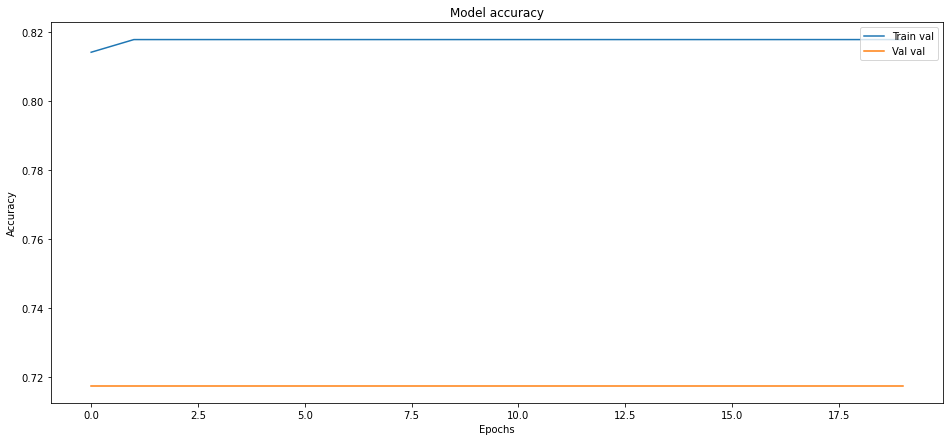

In [71]:
plot_accuracy(hist_3)

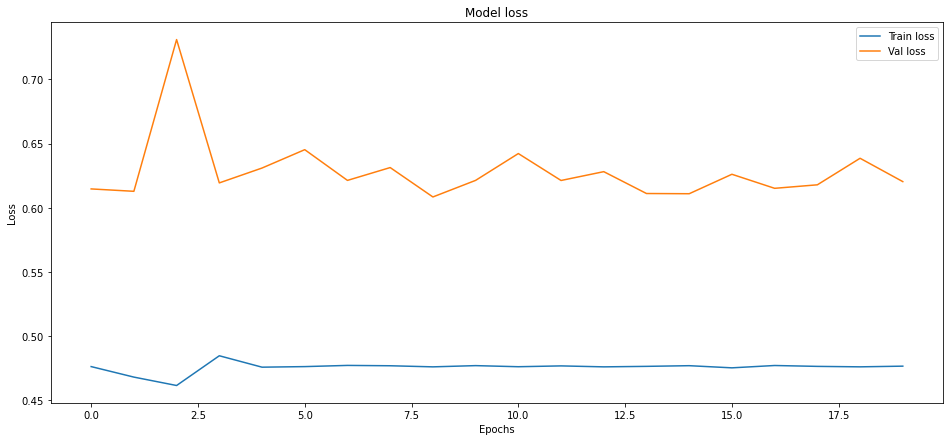

In [72]:
plot_loss(hist_3)

In [73]:
y_pred = model.predict_proba(feature_w4)
auc = roc_auc_score(lbl_w4, y_pred)
print(auc)

0.5


In [74]:
fpr, tpr, thresholds = roc_curve(lbl_w4, y_pred)

In [75]:
precision, recall, thresholds = precision_recall_curve(lbl_w4, y_pred)

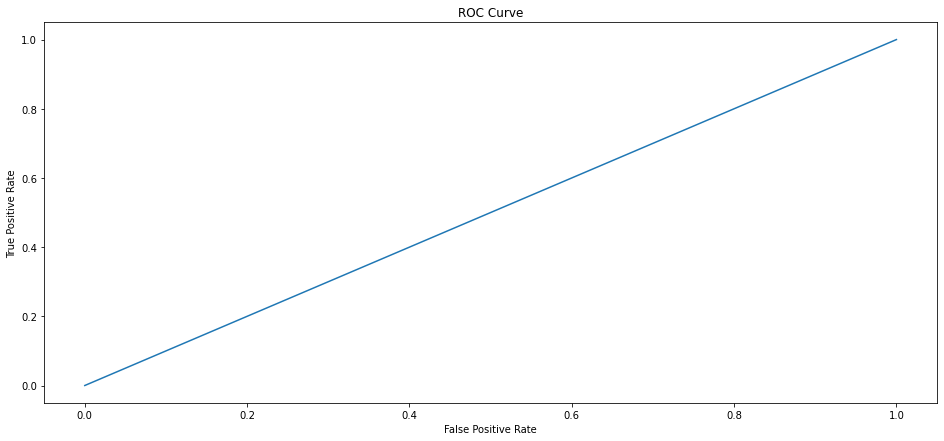

In [83]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

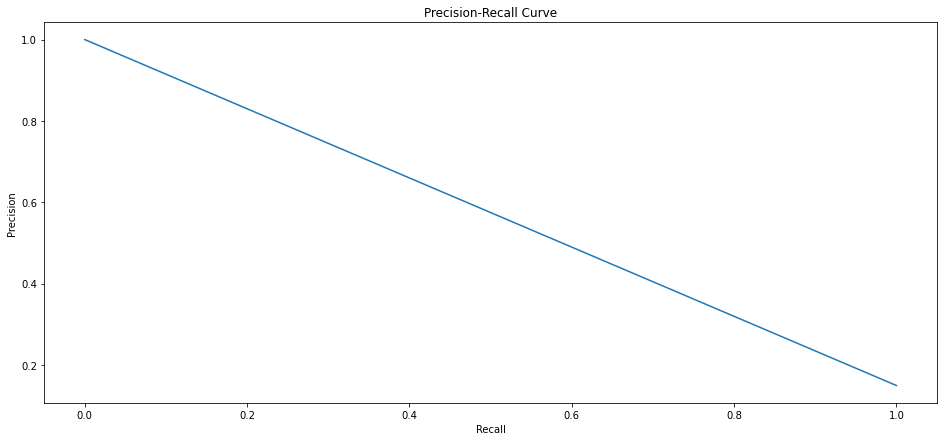

In [82]:
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Los resultados obtenido en este modelo no parece que han mejorado los resultados, es más, la línea curva ROC coincide con la línea con de no-discriminación, por esta razón es auc roc: 0.5.
En el modelo anterior la curva se acercaba al 80% de la curva (mayor era su capacidad discriminativa).